# PlantPal-PFE
## Diagnostique de maladie de plante
Ce projet à pour but de pouvoir diagnostiquer une maladie d'une certaine plante en recevant uniquement une image comme entrée, à l'aide de réseaux de neuronnes convolutifs

Les models utilisés pour le projets seront préentraînés puis fine-tuned avec nos données de plante, afin de maximiser la performance de notre model

Pour le données utilisé dans ce projet, nous avons décidés d'utiliser le dataset `plant_village`(https://www.tensorflow.org/datasets/catalog/plant_village?hl=fr), puisqu'il est suffisamment large pour être pertinent, puis assez documenté pour garantir une utilisation simple 

# Modules et bibliotèques python

### Import de bibliotèques

In [15]:
#General
import os
from prettytable import PrettyTable # package for printing easily tables

#Math
import numpy as np  # package for scientific computing with Python.
import matplotlib.pyplot as plt # 2D plotting library
from collections import Counter # dict subclass for counting hashable objects
from scipy import stats # package for statistical functions

#AI
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # package for metrics, used for confusion matrix
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras import utils
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAvgPool2D, GlobalAveragePooling2D, Activation, BatchNormalization, Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1
# Experiment tracking
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

#Image
import cv2

In [3]:
print("TensorFlow Version: ", tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    

TensorFlow Version:  2.10.0
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


# 1 - Analyse des données


## Charger le fichier de données

Statistiques des données

#### Code

In [4]:
IMG_SIZE = 128  # Size necessary for VGG19
DATADIR = '../../data'  # replace with your actual path

CATEGORIES = [folder for folder in os.listdir(DATADIR)] 
print(CATEGORIES)

dataset = []
X = []
Y = []

for category in CATEGORIES:
    print("Analysing " + category + "...")
    category_path = os.path.join(DATADIR, category)  # path to disease or healthy dir
    class_num = CATEGORIES.index(category)  # get the classification  (0 to 9)
    for plant_folder in os.listdir(category_path):
        plant_path = os.path.join(category_path, plant_folder)
        for img in os.listdir(plant_path):
            try:
                img_array = cv2.imread(os.path.join(plant_path, img))  # read the image
                img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
                dataset.append([img_resized, class_num])  # add it to the dataset. Not adding it to X and Y yet because we need to shuffle the dataset
            except Exception as e:
                print(e)
                pass


['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Leaf_Mold', 'Mosaic_virus', 'Powdery_mildew', 'Rust', 'Spider_mites', 'Target_Spot']
Analysing Bacterial_spot...
Analysing Early_blight...
Analysing Healthy...
Analysing Late_blight...
Analysing Leaf_Mold...
Analysing Mosaic_virus...
Analysing Powdery_mildew...
Analysing Rust...
Analysing Spider_mites...
Analysing Target_Spot...


# 2 - Préparation des données

#### Description
Normalisation des données et séparations des données en ensemble d'entraînement, de validation et de test. 

#### Code

In [5]:
#Shuffling data
np.random.shuffle(dataset)

# Split into features (X) and labels (Y)
for features, label in dataset:
    X.append(features)
    Y.append(label)

X = np.array(X)
Y = np.array(Y)

# Normalize X
#X = X / 255.0

# Split into train, valid and test, with a ratio of 70-15-15. Can be adapted later.
print("Splitting data...")
X_train = X[:int(len(X)*.7)]
Y_train = Y[:int(len(X)*.7)]
X_temp = X[int(len(X)*.7):]
Y_temp = Y[int(len(X)*.7):]

X_val = X_temp[:int(len(X_temp)*.5)]
Y_val = Y_temp[:int(len(X_temp)*.5)]
X_test = X_temp[int(len(X_temp)*.5):]
Y_test = Y_temp[int(len(X_temp)*.5):]

# Print the shapes
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("X_val shape: " + str(X_val.shape))

Splitting data...
X_train shape: (14439, 128, 128, 3)
X_test shape: (3095, 128, 128, 3)
X_val shape: (3094, 128, 128, 3)


### Pré-traitement des images


Prétraitement consistant d'un nettoyage des données en retirants les outliers, selon un z_score et un threshold donnée.

#### Code

In [6]:

def cleanZScore(data, ydata, threshold=1.65, removePercent=0.005):
    # Remove outliers from the dataset using z-score.
    z_scores = stats.zscore(data)
    outliers = np.where(np.abs(z_scores) > threshold)
    toRemoveIndex = []
    b = Counter(outliers[0])
    # Enleve un nombre `numDel` d'image.
    numDel = int(len(data) * removePercent)
    toRemove = b.most_common(numDel)
    for j in range(0,len(toRemove)):
           toRemoveIndex.append(toRemove[j][0])
    for i in toRemoveIndex:
       data = np.delete(data, i, axis=0)
       ydata = np.delete(ydata, i, axis=0)
    return data

#Removing outliers from the dataset using z-score.
print("Cleaning Training data ...")
cleanZScore(X_train, Y_train)
print("Cleaning Test data ...")
cleanZScore(X_test, Y_test)
print("Cleaning Validation data ...")
cleanZScore(X_val, Y_val)


Cleaning Training data ...
Cleaning Test data ...
Cleaning Validation data ...


array([[[[ 47,  89,  58],
         [ 47,  89,  58],
         [ 50,  92,  61],
         ...,
         [123, 191, 150],
         [112, 182, 141],
         [ 99, 171, 129]],

        [[ 51,  92,  61],
         [ 45,  87,  56],
         [ 38,  80,  49],
         ...,
         [120, 187, 146],
         [112, 181, 140],
         [120, 192, 150]],

        [[ 39,  81,  50],
         [ 40,  82,  51],
         [ 38,  80,  49],
         ...,
         [120, 187, 146],
         [144, 213, 172],
         [141, 211, 170]],

        ...,

        [[ 76, 123,  97],
         [ 95, 143, 117],
         [ 71, 124,  97],
         ...,
         [ 69, 115,  96],
         [ 81, 126, 109],
         [ 67, 112,  95]],

        [[ 49,  95,  69],
         [ 75, 122,  96],
         [ 53, 103,  77],
         ...,
         [ 86, 132, 113],
         [ 75, 123, 105],
         [102, 150, 132]],

        [[ 66, 109,  84],
         [ 69, 116,  90],
         [ 52, 101,  75],
         ...,
         [ 90, 136, 117],
        

### One-hot encode labels

Pour notre réseau de neurone, nous aurons besoin des étiquettes en mode one-hot encoded

In [7]:
ytrain = utils.to_categorical(Y_train)
yval   = utils.to_categorical(Y_val)
ytest  = utils.to_categorical(Y_test)

## Visualisation Data

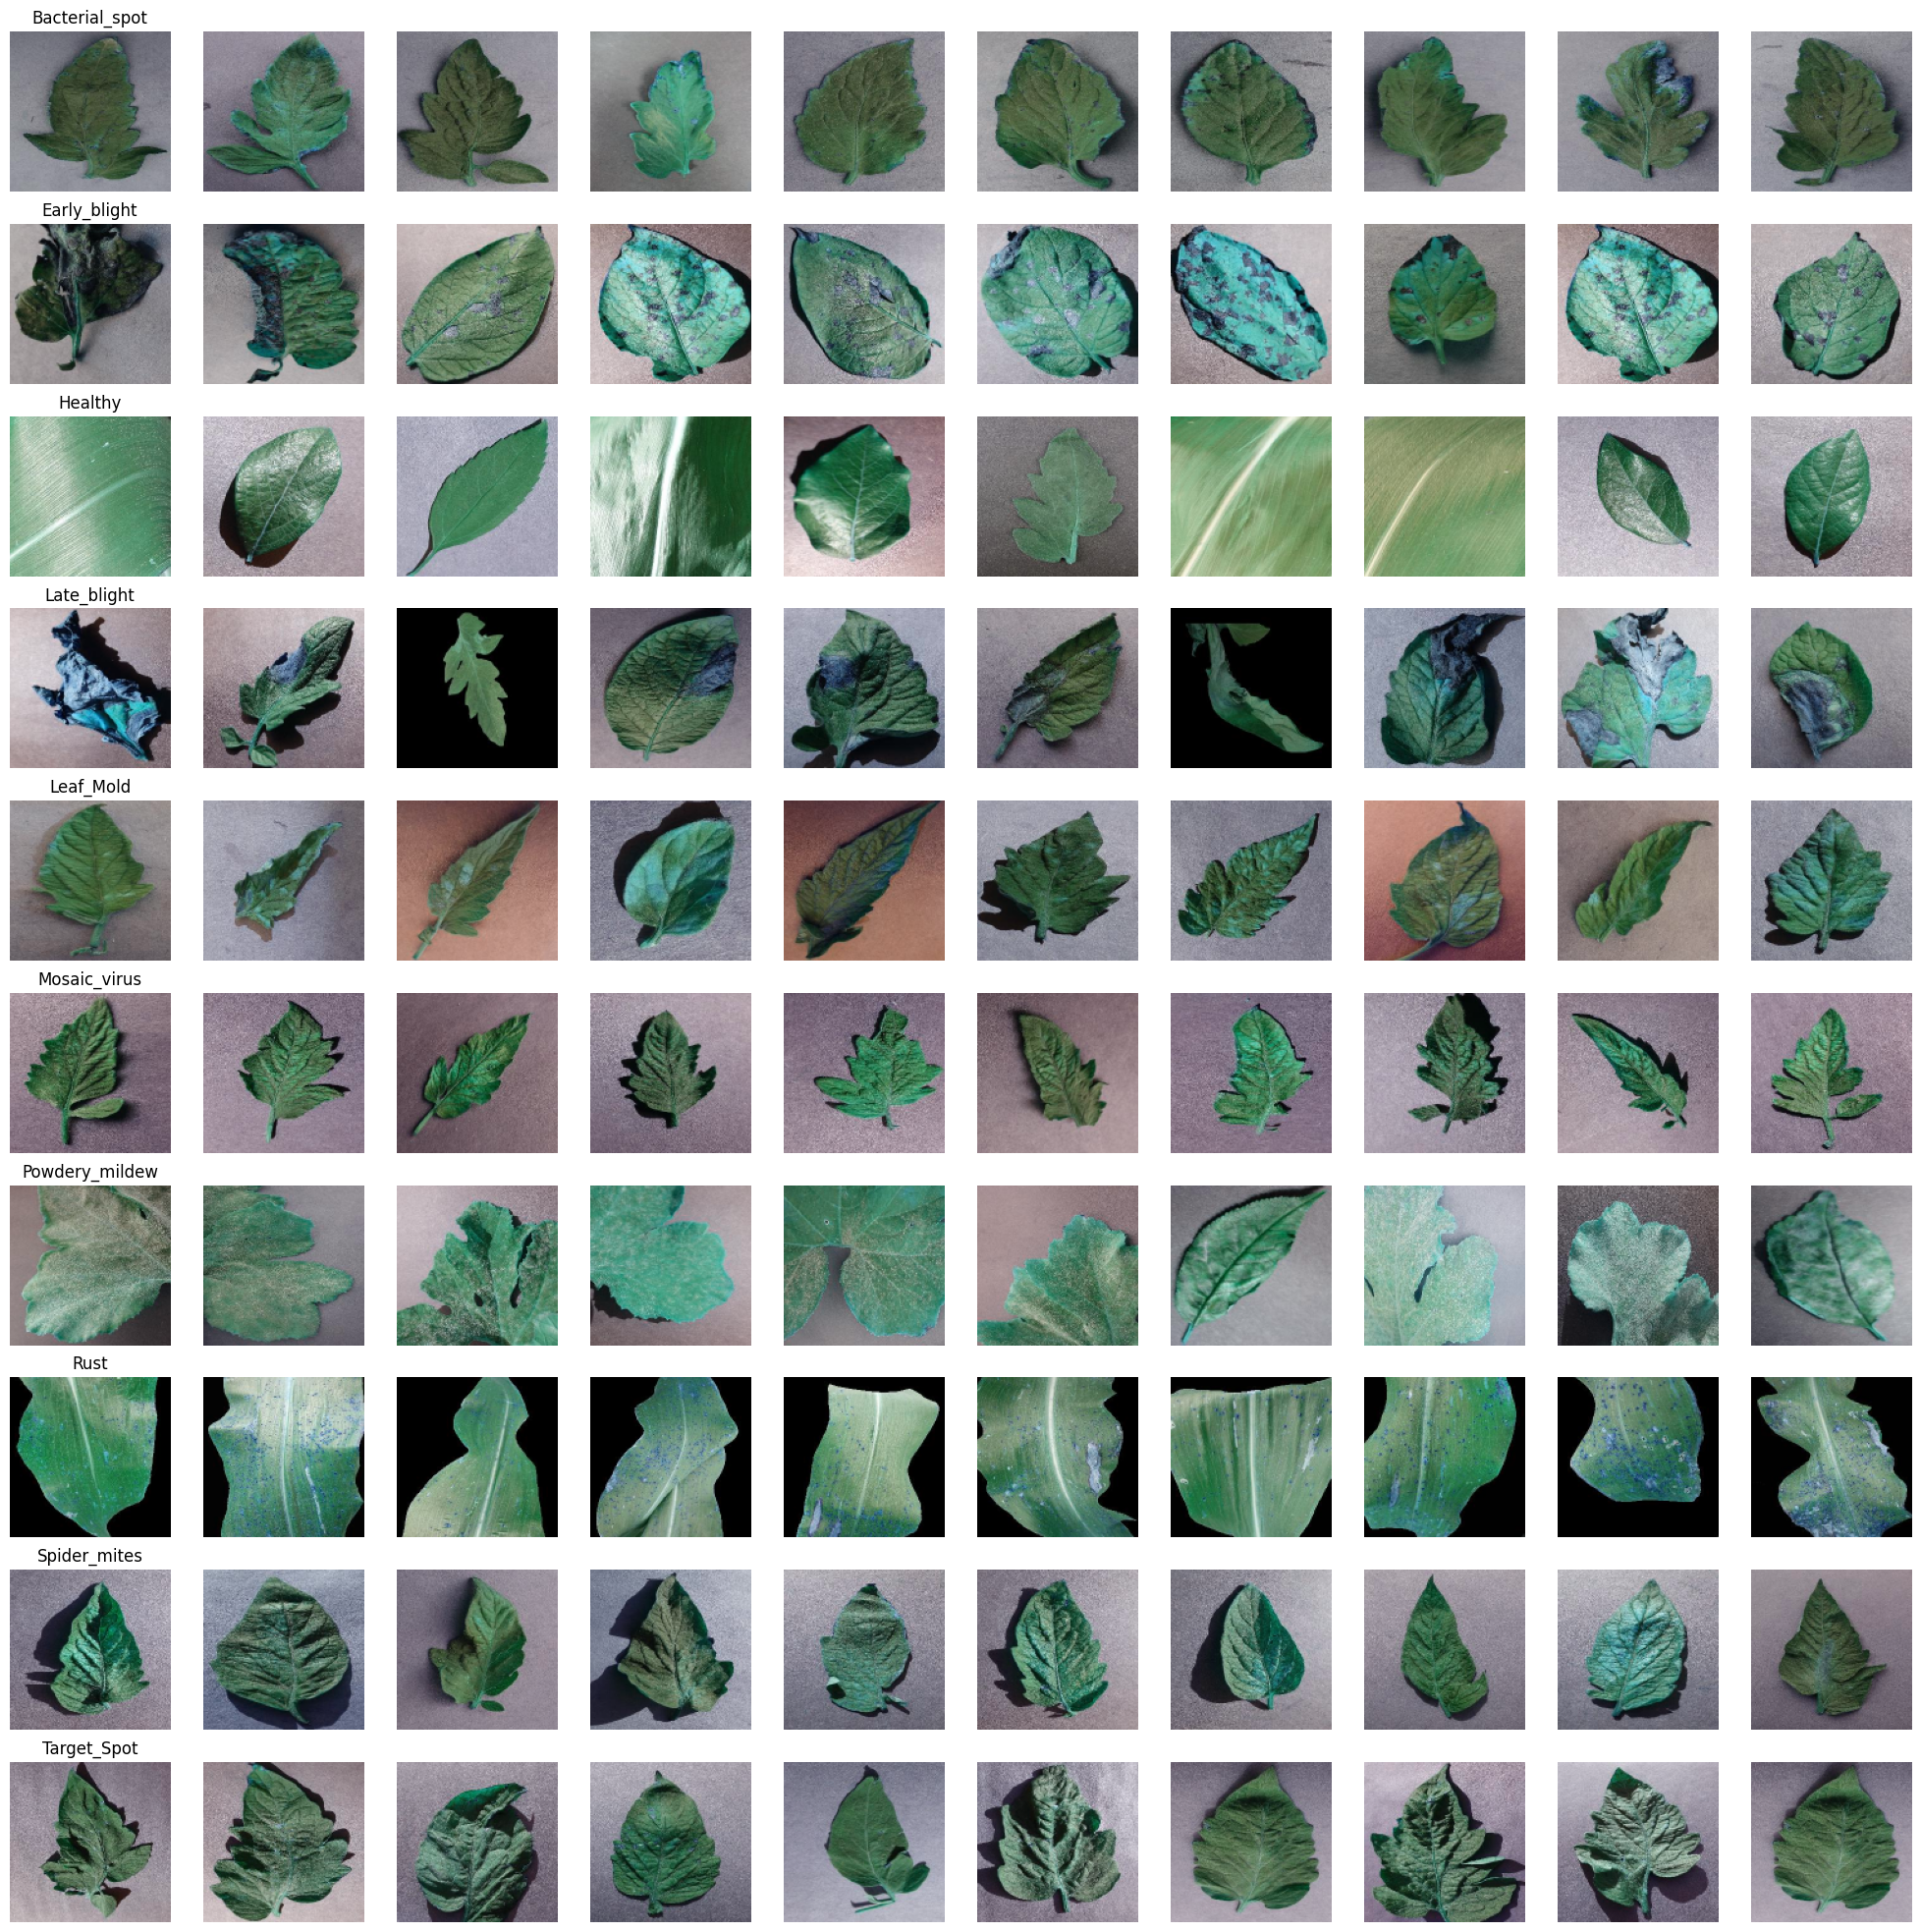

In [8]:
#Cette fonction roule jusqua ce quelle trouve une photo d'une classe spécifique puis retourne l'index.
def getRandomPicture(image_class, len_max, data):
    while True:
        idx = np.random.randint(len_max)
        idclass = data[idx]
        if idclass == image_class:
            return idx

# Définir les dimensions de la grille
rows = 10
cols = 10

labels = CATEGORIES
# Créer des figures vides pour le tableau
fig, axs = plt.subplots(rows, cols, figsize=(25, 25))

# Boucle sur les lignes de la grille
for i in range(rows):
    # Boucle sur les colonnes de la grille
    for j in range(cols):
        #Fonction définie plus haut pour aller chercher une image random d'une certaine emotion
        idx = getRandomPicture(i, X_train.shape[0], Y_train)
        
        # Choisir un indice aléatoire pour un échantillon
        # Afficher l'image à l'emplacement courant de la grille
        axs[i, j].imshow(X_train[idx])
        axs[i, j].axis('off')
        
    #Afficher le titre de chaque emotions
    axs[i, 0].set_title(labels[i])

# Distribution du data
Est-ce que notre ensemble de données est équilibré ?


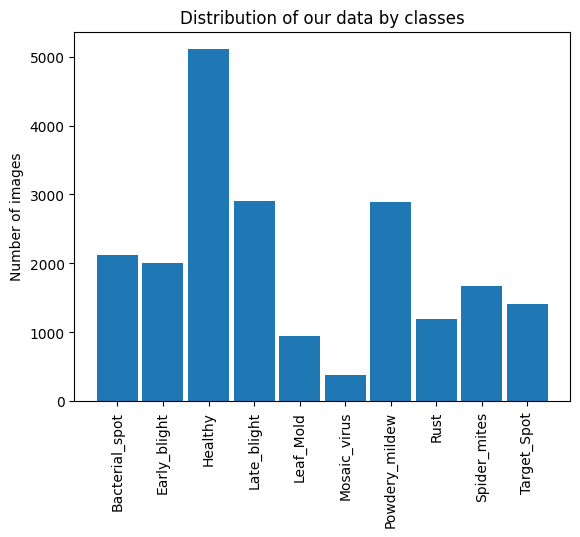

In [9]:
labels = CATEGORIES
counter = Counter(Y)

# Sort by class label
sorted_items = sorted(counter.items())

# Separate labels and counts
labels, counts = zip(*sorted_items)

# Create bar chart
plt.bar(labels, counts, tick_label=CATEGORIES, align='center',width=0.9)

plt.ylabel("Number of images")
plt.xticks(rotation='vertical')
plt.title("Distribution of our data by classes")
plt.show()


# Setup experiment tracker

In [20]:
# General training parameters
nb_epoch    = 60
batch_size  = 32
learning_rate = 5e-4
weight_decay = 1e-4
 # Setup Wandb
run = wandb.init(
# Set the project where this run will be logged
project="plantpal-ML",
name="fineTune EffNetb1 V2",
resume="allow", # See https://docs.wandb.ai/guides/runs/resuming
# Track hyperparameters and run metadata
config={
    "learning_rate": learning_rate,
    "epochs": nb_epoch,
    "weight_decay": weight_decay,
    "batch_size": batch_size,
},
)

## Create model from scratch

In [15]:
def createModelResnet9(): #This is the architecture of a ResNet9 model
    nb_classes = 10
    model = Sequential()
    # --------------------------------------------
    model.add(Input(shape = X_train[0].shape))
    model.add(Conv2D(64,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(strides=4, pool_size=(2,2), padding='same'))

    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(256,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(strides=4, pool_size=(2,2), padding='same'))

    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(strides=4, pool_size=(2,2), padding='same'))

    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(strides=4, pool_size=(2,2), padding='same'))

    model.add(Flatten())

    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ['accuracy'] )
    
    model.summary()
    
    return model

model = createModelResnet9()
callbacks_list = []

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 128)    512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128, 128, 128)     0

# Train model

In [16]:

#Data Augmentation, using ImageDataGenerator
train_gen = ImageDataGenerator(rotation_range=40,shear_range=0.15, width_shift_range=0.15, height_shift_range=0.15)
train_generator = train_gen.flow(X_train, ytrain, batch_size=batch_size)



#fitting the model 
hist = model.fit(train_generator,
                      validation_data = (X_val, yval),
                      batch_size = batch_size, 
                      epochs = nb_epoch,
                      verbose = 1,
                      shuffle = True
                    )

fix, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(np.arange(0, nb_epoch), hist.history["loss"], label="train_loss")
axes[0].plot(np.arange(0, nb_epoch), hist.history["val_loss"], label="val_loss")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch #")
axes[0].set_ylabel("Loss")
axes[0].legend(["Train", "Validation"],loc="upper left")

axes[1].plot(np.arange(0, nb_epoch), hist.history["accuracy"], label="train_acc")
axes[1].plot(np.arange(0, nb_epoch), hist.history["val_accuracy"], label="val_acc")
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch #")
axes[1].set_ylabel("Accuracy")
axes[1].legend(["Train", "Validation"], loc="upper left")
plt.show()

Epoch 1/60
452/452 [==============================] - 91s 199ms/step - loss: 0.9131 - accuracy: 0.6925 - val_loss: 4.5337 - val_accuracy: 0.3668
Epoch 2/60
452/452 [==============================] - 90s 199ms/step - loss: 0.5084 - accuracy: 0.8255 - val_loss: 0.6176 - val_accuracy: 0.8264
Epoch 3/60
452/452 [==============================] - 90s 199ms/step - loss: 0.3776 - accuracy: 0.8720 - val_loss: 2.5930 - val_accuracy: 0.5365
Epoch 4/60
452/452 [==============================] - 90s 199ms/step - loss: 0.3027 - accuracy: 0.9008 - val_loss: 1.2769 - val_accuracy: 0.6800
Epoch 5/60
452/452 [==============================] - 90s 199ms/step - loss: 0.2978 - accuracy: 0.9009 - val_loss: 1.9358 - val_accuracy: 0.6273
Epoch 6/60
452/452 [==============================] - 90s 199ms/step - loss: 0.2475 - accuracy: 0.9172 - val_loss: 1.6043 - val_accuracy: 0.6193
Epoch 7/60
452/452 [==============================] - 90s 199ms/step - loss: 0.2060 - accuracy: 0.9332 - val_loss: 1.7437 - val_ac

: 

: 

# ModelPlantPal01 graph
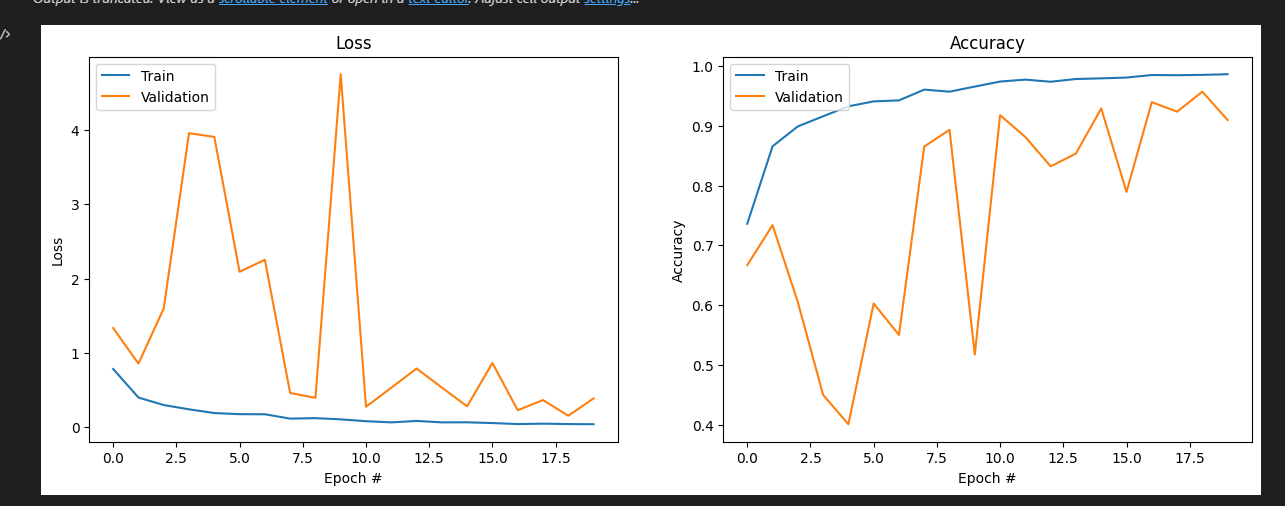

# FineTuning EffnetB1

In [17]:
inp = Input(shape = X_train[0].shape, name="input")


efficient_net = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(128,128,3))

# Output layer
flat = Flatten()(efficient_net(inp))
drop = Dropout(0.5)(flat)
dense = Dense(10, activation="softmax", name="output")(drop)
modelEffNet = Model(inp, dense)
modelEffNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])
modelEffNet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 4, 4, 1280)       6575239   
                                                                 
 flatten_2 (Flatten)         (None, 20480)             0         
                                                                 
 dropout_2 (Dropout)         (None, 20480)             0         
                                                                 
 output (Dense)              (None, 10)                204810    
                                                                 
Total params: 6,780,049
Trainable params: 6,717,994
Non-trainable params: 62,055
_________________________________________________________________


Epoch 1/60
  6/452 [..............................] - ETA: 3:46 - loss: 0.0983 - accuracy: 0.9531WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2057s vs `on_train_batch_end` time: 0.3008s). Check your callbacks.


452/452 [==============================] - 239s 529ms/step - loss: 0.1330 - accuracy: 0.9611 - val_loss: 0.2297 - val_accuracy: 0.9551
Epoch 2/60
452/452 [==============================] - 239s 529ms/step - loss: 0.1012 - accuracy: 0.9711 - val_loss: 0.4885 - val_accuracy: 0.9357
Epoch 3/60
452/452 [==============================] - 239s 529ms/step - loss: 0.1261 - accuracy: 0.9674 - val_loss: 0.3698 - val_accuracy: 0.9557
Epoch 4/60
452/452 [==============================] - 239s 529ms/step - loss: 0.1040 - accuracy: 0.9721 - val_loss: 0.0624 - val_accuracy: 0.9871
Epoch 5/60
452/452 [==============================] - 239s 530ms/step - loss: 0.0818 - accuracy: 0.9788 - val_loss: 0.9470 - val_accuracy: 0.9085
Epoch 6/60
452/452 [==============================] - 239s 528ms/step - loss: 0.3684 - accuracy: 0.9455 - val_loss: 0.1526 - val_accuracy: 0.9690
Epoch 7/60
452/452 [==============================] - 239s 528ms/step - loss: 0.1200 - accuracy: 0.9726 - val_loss: 0.0893 - val_accura

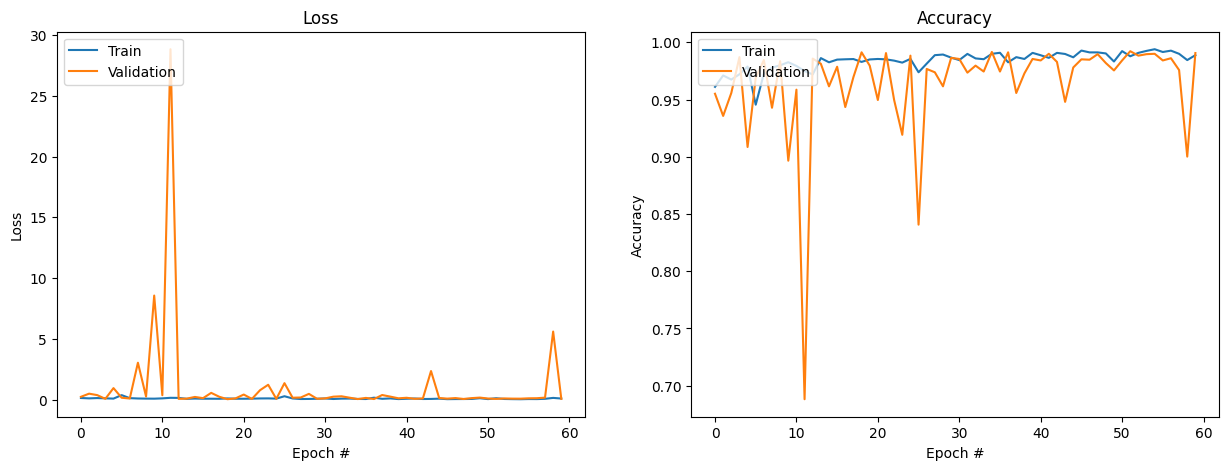

In [21]:



#Using ImageDataGenerator to augment the data
train_gen = ImageDataGenerator(rotation_range=40,shear_range=0.15, width_shift_range=0.15, height_shift_range=0.15)
train_generator = train_gen.flow(X_train, ytrain, batch_size=batch_size)

model_data = modelEffNet.fit(train_generator, validation_data=(X_val, yval), epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[WandbMetricsLogger(log_freq=3)])
fix, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(np.arange(0, nb_epoch), model_data.history["loss"], label="train_loss")
axes[0].plot(np.arange(0, nb_epoch), model_data.history["val_loss"], label="val_loss")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch #")
axes[0].set_ylabel("Loss")
axes[0].legend(["Train", "Validation"],loc="upper left")

axes[1].plot(np.arange(0, nb_epoch), model_data.history["accuracy"], label="train_acc")
axes[1].plot(np.arange(0, nb_epoch), model_data.history["val_accuracy"], label="val_acc")
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch #")
axes[1].set_ylabel("Accuracy")
axes[1].legend(["Train", "Validation"], loc="upper left")
plt.show()

In [24]:
wandb.finish()

## Evaluate our model

97/97 [==============================] - 10s 106ms/step
Report de classification
                precision    recall  f1-score   support

Bacterial_spot       1.00      1.00      1.00      2127
  Early_blight       1.00      1.00      1.00      2000
       Healthy       0.99      1.00      1.00      5108
   Late_blight       1.00      0.99      1.00      2909
     Leaf_Mold       1.00      1.00      1.00       952
  Mosaic_virus       1.00      1.00      1.00       373
Powdery_mildew       1.00      0.99      1.00      2887
          Rust       1.00      1.00      1.00      1192
  Spider_mites       0.98      1.00      0.99      1676
   Target_Spot       0.99      0.97      0.98      1404

      accuracy                           0.99     20628
     macro avg       1.00      0.99      0.99     20628
  weighted avg       0.99      0.99      0.99     20628

FER MLP test accuracy - last model: 99.42%
FER MLP test error    - last model: 0.58%
Taux de classification sur les 3 ensembles
+---

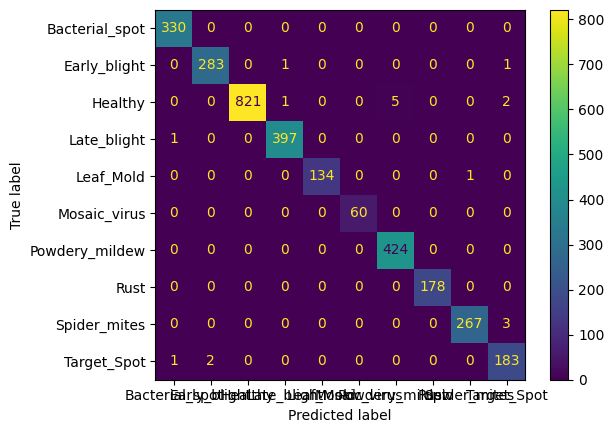

In [23]:
model = modelEffNet
labels = CATEGORIES

scoresTrain = model.evaluate(X_train, ytrain, verbose=0)
ypredtrain = model.predict(X_train)

scoresVal = model.evaluate(X_val, yval, verbose=0)
ypredval = model.predict(X_val)

scoresTest = model.evaluate(X_test, ytest, verbose=0)
ypredtest = model.predict(X_test)

ytruegenerals = np.concatenate((ytrain.argmax(axis=1), yval.argmax(axis=1), ytest.argmax(axis=1)), axis=0)
ypredgenerals = np.concatenate((ypredtrain.argmax(axis=1), ypredval.argmax(axis=1), ypredtest.argmax(axis=1)), axis=0)

print("Report de classification")
print(classification_report(ytruegenerals,ypredgenerals, target_names=labels))

print("FER MLP test accuracy - last model: %.2f%%" % (scoresTest[1]*100))
print("FER MLP test error    - last model: %.2f%%" % (100-scoresTest[1]*100))

#Tableau de comparaison d'accuracy
print("Taux de classification sur les 3 ensembles")
table = PrettyTable(["Ensemble", "Accuracy (%)"])
table.add_row(["App", round(scoresTrain[1]*100,2)])
table.add_row(["Val", round(scoresVal[1]*100,2)])
table.add_row(["Test", round(scoresTest[1]*100,2)])
print(table)

confusion_matrix = metrics.confusion_matrix(ypredtest.argmax(axis=1), ytest.argmax(axis=1))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels =labels)
cm_display.plot()
plt.show()

# Save the model

In [22]:
#modelEffNet.save("../../AIModels/modelPlantPalLatest")
modelEffNet.save_weights("../../AIModels/modelPlantPalLatestWeightsB1")

# Load model

In [10]:

inp = Input(shape = X_train[0].shape, name="input")


efficient_net = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(128,128,3))

# Output layer
flat = Flatten()(efficient_net(inp))
drop = Dropout(0.5)(flat)
dense = Dense(10, activation="softmax", name="output")(drop)
newModel = Model(inp, dense)
newModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])
newModel.summary()

newModel.load_weights("../../AIModels/modelPlantPalLatestWeightsB1")    
#loss, acc = newModel.evaluate(X_test, ytest, verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 output (Dense)              (None, 10)                204810    
                                                                 
Total params: 4,254,381
Trainable params: 4,212,358
Non-trainable params: 42,023
_________________________________________________________________


In [45]:

size =128
categories = ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Leaf_Mold', 'Mosaic_virus', 'Powdery_mildew', 'Rust', 'Spider_mites', 'Target_Spot']

loaded_model = newModel

images = []

for image in os.listdir("testData"):
    img_array = cv2.imread(os.path.join("testData", image))
    img_resized = cv2.resize(img_array, (size, size))
    images.append(img_resized)

images = np.array(images)
pred = loaded_model.predict(images)

for i in range(len(images)):
    print(pred[i])
    max = np.argmax(pred[i])
    confidence = pred[i][max]
    print("Image ",i,", Predicting : ", categories[max], ", with confidence : ", confidence)
print("done !")

1/1 [==============================] - 0s 29ms/step
[4.8483181e-19 1.0000000e+00 7.9004828e-21 1.7192481e-18 2.0257346e-16
 1.2161118e-23 1.3632640e-22 7.1923904e-20 9.1583586e-22 5.2274855e-16]
Image  0 , Predicting :  Early_blight , with confidence :  1.0
done !


## Test and load model
